In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

import sklearn.metrics as metrics
from sklearn.metrics import r2_score

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


import calendar
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [148]:
train = pd.read_csv("./train.csv")


In [149]:
train.isnull().values.any()

False

In [150]:
train[train.isnull().values]


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


No missing values

In [151]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [152]:
train.shape

(10886, 12)

In [153]:
train["season"] = train.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
train["weather"] = train.weather.map({1: " Clear + Few clouds + Partly cloudy + Partly cloudy",\
                                        2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", \
                                        3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", \
                                        4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " })
train["holiday"] = train.holiday.map({1: "holiday", 0 : "non-holiday"})
train["workingday"] = train.workingday.map({1: "workingday", 0 : "non-workingday"})



##### One of the columns is "datetime". We convert it from string Date time into Python Date time object.

In [154]:
train['datetime'] = pd.to_datetime(train['datetime'])
#test['datetime'] = pd.to_datetime(test['datetime'])


In [155]:
train['Year'] = train['datetime'].dt.year
train["hour"] = train["datetime"].dt.hour

train["month"] = train["datetime"].dt.month
train['month'] = train['month'].apply(lambda x: calendar.month_name[x])

train["DayOfWeek"] = train["datetime"].dt.weekday
train['DayOfWeek'] = train['DayOfWeek'].apply(lambda x: calendar.day_name[x])




In [156]:
train= train.drop(labels=["datetime"], axis="columns")


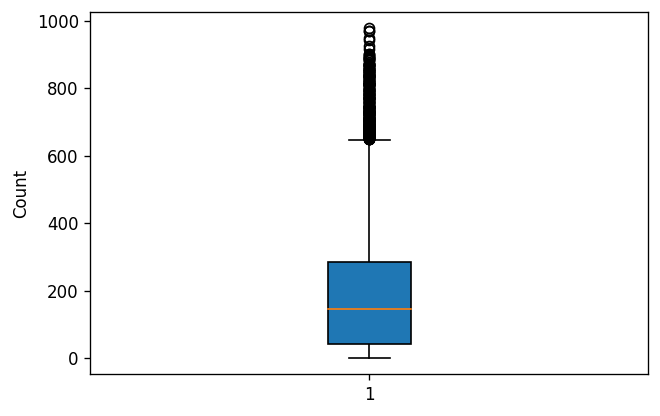

In [157]:
fig, ax = plt.subplots(dpi = 120)
ax.boxplot(x=train["count"],patch_artist = True)
ax.set(ylabel='Count')
plt.show()





As we see in the box plot there are outliers that are not included in the box and they are fat from the quartiles.



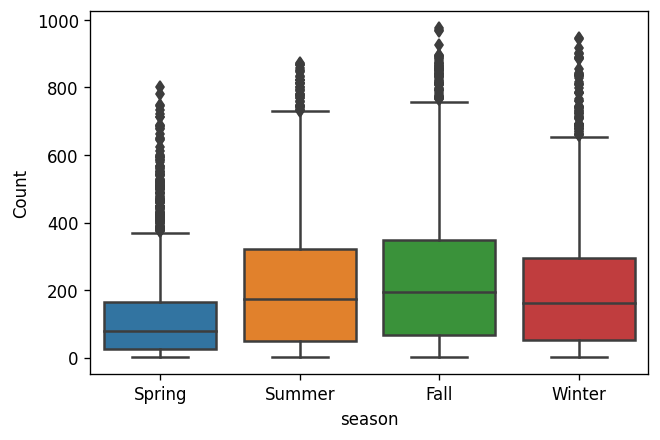

In [158]:
fig, ax = plt.subplots(dpi = 120)

sns.boxplot(data=train,y="count",x="season",orient="v")
ax.set(ylabel='Count')
plt.show()

As we see above we have multivariate outliers as well.

## Remove Outliers:


In [159]:
Q1 = train['count'].quantile(0.25)
Q3 = train['count'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

outliers = train[(train['count'] < (Q1 - 1.5 * IQR)) | (train['count'] > (Q3 + 1.5 * IQR))]
print((len(outliers)/(len(train)))*100)

242.0
2.75583318023149


* We see that about %2.75 of the target values are outliers. So we should remove them:

In [160]:
train = train.drop(outliers.index)


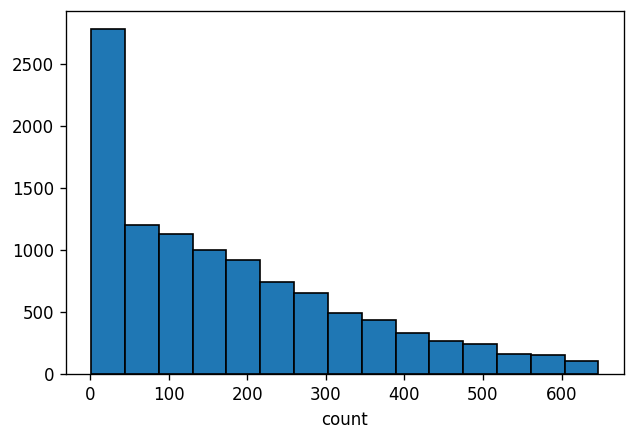

In [161]:
fig, ax = plt.subplots(dpi = 120)
ax.hist(train["count"], bins=15, edgecolor='black')
ax.set_xlabel("count")
plt.show()

##### The graph above shows the distribution of Count. It can be seen that it is very dense between 0-200.



We are going to use np.log1p which is np.log(1+y) because if a certain value of count is zero it does not converge to infinity

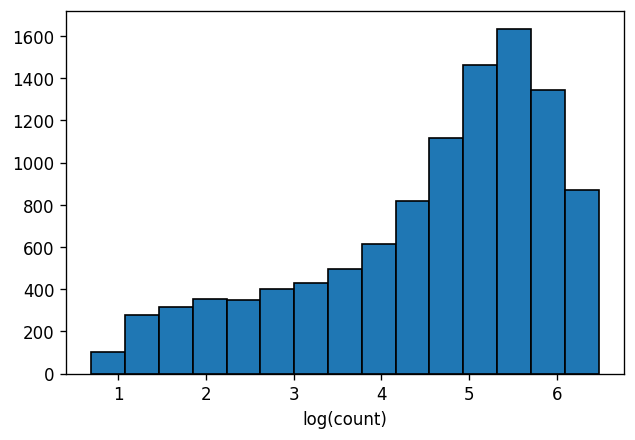

In [162]:
log_count = np.log1p(train["count"])
fig, ax = plt.subplots(dpi = 120)
ax.hist(log_count, bins=15, edgecolor='black')
ax.set_xlabel("log(count)")
plt.show()

### We find the correlation between the pairs of the variables using correlation matrix and then use heatmap plot to represent how strong the pair of variables can be correlated

<AxesSubplot:>

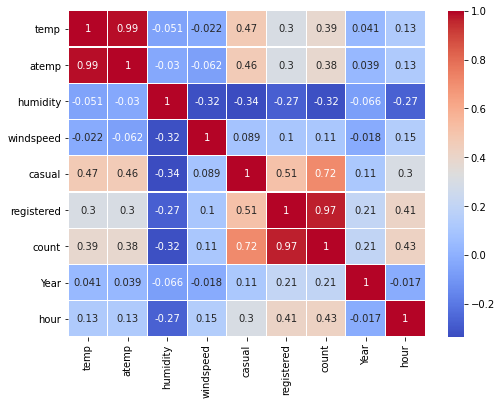

In [163]:
plt.figure(figsize = (8,6))
train_corr = train.corr()
sns.heatmap(train_corr, annot = True, cmap = 'coolwarm', linecolor = 'white', linewidths=0.1)

As we see the variable count has a strong correlation with registered and casual variables, therefore we drop these two features:

In [164]:
train= train.drop(labels=["casual"], axis="columns")
train= train.drop(labels=["registered"], axis="columns")

### Let's look at the relationship between Count and other variables.


### Convert to categorical variables:

In [165]:
cat_list = ["DayOfWeek", "season", "month", "workingday","hour","weather", "holiday"]

for cat in cat_list:
    train[cat] = train[cat].astype("category")


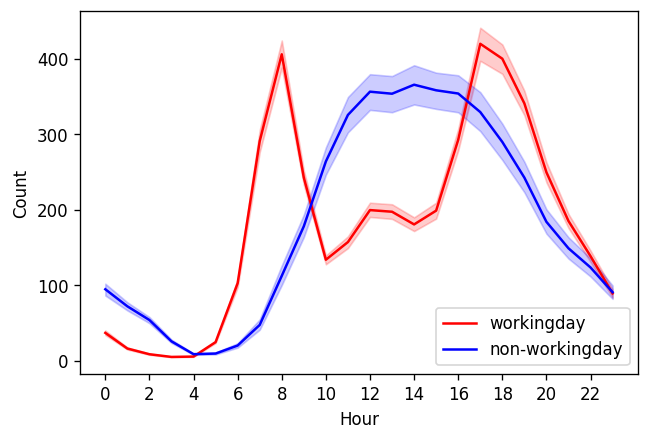

In [166]:
fig, ax = plt.subplots(dpi = 120)
x1=train[train.workingday=="workingday"]["hour"].values
y1=train[train.workingday=="workingday"]["count"].values

x2=train[train.workingday=="non-workingday"]["hour"].values
y2=train[train.workingday=="non-workingday"]["count"].values

sns.lineplot(x=x1,y=y1, label="workingday", color="r")
sns.lineplot(x=x2,y=y2, label="non-workingday", color="blue")

ax.set_xlabel("Hour")
ax.set_ylabel("Count")

ax.set_xticks(np.arange(0,24,2))

plt.legend()

plt.show()
fig.savefig("hour_count.png",facecolor='w', dpi=600)

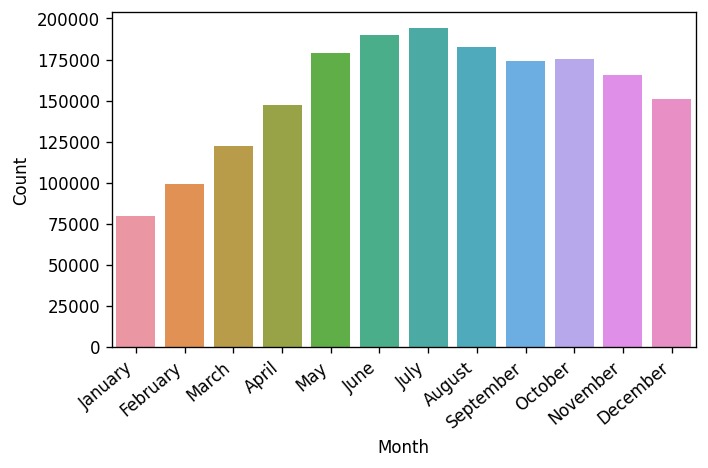

In [167]:
### Working day: There is a peak in number of rentals in the moring at about 8am and also in the evening around 5pm to 6pm, which makes sense as the people go to work in the morning and come home from work in the evening so there is more demand in these times of the day.
### Non-Working day :  the highest rental counts is around noon

ordered_months = ["January","February","March",\
             "April","May","June","July","August","September","October","November","December"]
month_count = train.groupby("month")["count"].sum()
month_count
fig, ax = plt.subplots(dpi = 120)
ax = sns.barplot(x=month_count.index.values,y=month_count.values, order=ordered_months)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

ax.set_xlabel("Month")
ax.set_ylabel("Count")

plt.tight_layout()

plt.show()
fig.savefig("month_count.png",facecolor='w', dpi=600)

### There is high demand in renting bike between June to September

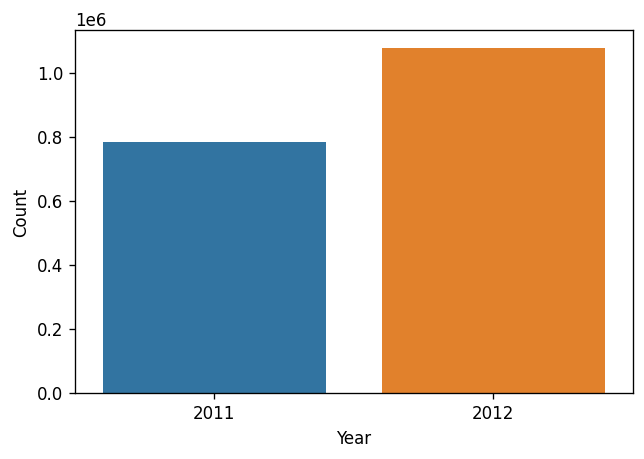

In [168]:
Year_count = train.groupby("Year")["count"].sum()
fig, ax = plt.subplots(dpi = 120)
ax = sns.barplot(x=Year_count.index.values,y=Year_count.values)
ax.set_xlabel("Year")
ax.set_ylabel("Count")
plt.show()
fig.savefig("year_count.png",facecolor='w', dpi=600)

### We see that there is a very higher bike rental in 2012 comparing 2011.

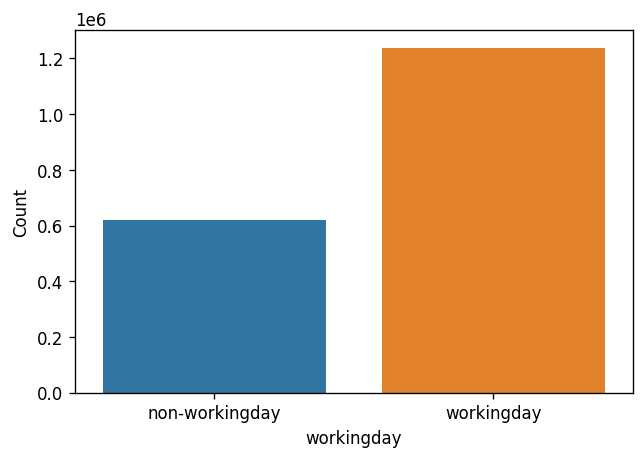

In [169]:
workingday_count = train.groupby("workingday")["count"].sum()
fig, ax = plt.subplots(dpi = 120)
ax = sns.barplot(x=workingday_count.index.values,y=workingday_count.values)
ax.set_xlabel("workingday")
ax.set_ylabel("Count")
plt.show()
fig.savefig("workingday_count.png",facecolor='w', dpi=600)

### It is reasonable that people rent more bikes during the week.

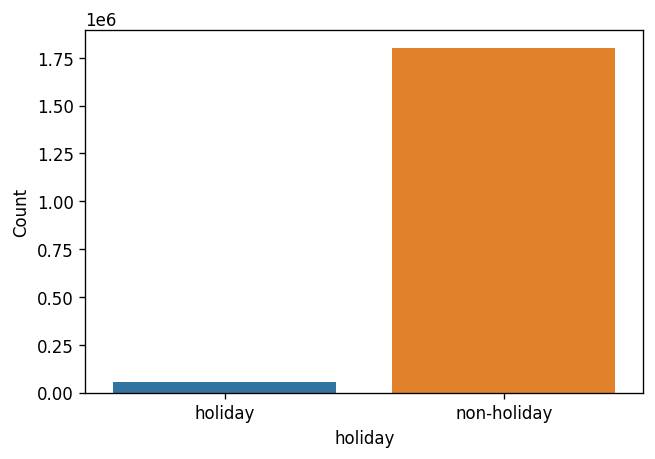

In [170]:
holiday_count = train.groupby("holiday")["count"].sum()
fig, ax = plt.subplots(dpi = 120)
ax = sns.barplot(x=holiday_count.index.values,y=holiday_count.values)
ax.set_xlabel("holiday")
ax.set_ylabel("Count")
plt.show()
fig.savefig("holiday_count.png",facecolor='w', dpi=600)

### It makes sense that people rent bikes when it is not holiday


In [171]:
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,Year,hour,month,DayOfWeek
0,Spring,non-holiday,non-workingday,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,81,0.0,16,2011,0,January,Saturday
1,Spring,non-holiday,non-workingday,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,40,2011,1,January,Saturday
2,Spring,non-holiday,non-workingday,Clear + Few clouds + Partly cloudy + Partly c...,9.02,13.635,80,0.0,32,2011,2,January,Saturday
3,Spring,non-holiday,non-workingday,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,13,2011,3,January,Saturday
4,Spring,non-holiday,non-workingday,Clear + Few clouds + Partly cloudy + Partly c...,9.84,14.395,75,0.0,1,2011,4,January,Saturday


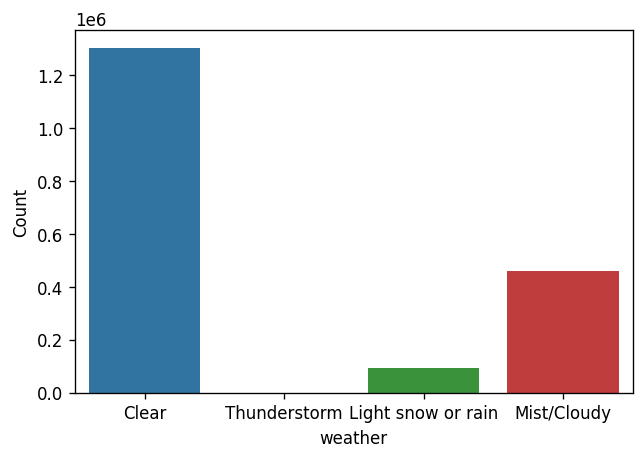

In [172]:
weather_count = train.groupby("weather")["count"].sum()
x_val = ["Clear", "Thunderstorm", "Light snow or rain", "Mist/Cloudy"]
fig, ax = plt.subplots(dpi = 120)
ax = sns.barplot(x=x_val,y=weather_count.values)
#ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

ax.set_xlabel("weather")
ax.set_ylabel("Count")
plt.show()
fig.savefig("weather_count.png",facecolor='w', dpi=600)

# Modelling:

In [173]:
train_new = pd.get_dummies(train,columns=["season","holiday", "workingday", "weather", "month", "DayOfWeek"], drop_first=True)


In [174]:
train.shape

(10586, 13)

###### Transform y by log(1+y) and then split data to test and train set:

In [175]:
y = np.log1p(train_new["count"])
X=train_new.drop(["count"], axis="columns")

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0)

In [176]:
def rmsle(y, y_pred):
    y = np.exp(y),
    y_pred = np.exp(y_pred)
    log1 = (np.array([np.log(k + 1) for k in y]))
    log2 = (np.array([np.log(k + 1) for k in y_pred]))
    sqe = (log1 - log2) ** 2
    return np.sqrt(np.mean(sqe))

# Linear Regression

In [177]:
model1 = Pipeline([

    ('linear_regression', LinearRegression())
])

In [178]:
#Cross validation

cv_score=cross_val_score(model1, Xtrain, ytrain, cv=10, scoring=make_scorer(rmsle))
print('linear_regression_model', cv_score.mean())

linear_regression_model 0.9594082071500752


Find the error on the test data set:

In [179]:
model1  =model1.fit(Xtrain, ytrain)
y_pred_lin_reg = model1.predict(Xtest)
rmsle(ytest, y_pred_lin_reg)

0.9483997478834296

In [180]:
coefficient_of_dermination_lin_reg = r2_score(ytest, y_pred_lin_reg)


In [181]:
print(f"R2 for linear model:{coefficient_of_dermination_lin_reg}")

R2 for linear model:0.4981538831080454


# Ridge Regression

In most of the models, first I just test the model with a value for its hyper paramters and then in the cell tuned the paramters using GridSearchCV. I reported the minimum CV errors using the optimal hyperparameter values in the report. 

In [182]:
# I just tried alpha=0.1 but in the nect cell I tuned the value 
# and report that value in the result section
model_ridge_reg= Pipeline([

    ("ridge_reg", Ridge(alpha=0.1, fit_intercept=True))
])

cv_score_new=cross_val_score(model_ridge_reg, Xtrain, ytrain, cv=10, scoring=make_scorer(rmsle))
print('Ridge_linear_regression_model', cv_score.mean())

Ridge_linear_regression_model 0.9594082071500752


In [183]:
model_ridge_reg =model_ridge_reg.fit(Xtrain, ytrain)
y_pred_ridge_reg = model_ridge_reg.predict(Xtest)
rmsle(ytest, y_pred_ridge_reg)

0.9483997671807107

In [184]:
coefficient_of_dermination_ridge = r2_score(ytest, y_pred_ridge_reg)
print(f"R2 for Ridge regression:{coefficient_of_dermination_ridge}")

R2 for Ridge regression:0.4981535794783827


In [191]:
params = {'ridge_reg__alpha': (np.linspace(0.001,10,20))}
gscv = GridSearchCV(model_ridge_reg, param_grid=params, cv=10, scoring = make_scorer(rmsle), refit=True)
gscv.fit(Xtrain, ytrain)

results = pd.DataFrame(gscv.cv_results_)


In [192]:
gscv.best_params_

{'ridge_reg__alpha': 0.001}

In [193]:
model_ridge_reg_new= Pipeline([

    ("ridge_reg_new", Ridge(alpha=gscv.best_params_["ridge_reg__alpha"], fit_intercept=True))
])



In [194]:
cv_score_new=cross_val_score(model_ridge_reg_new, Xtrain, ytrain, cv=10, scoring=make_scorer(rmsle,greater_is_better=False))
print('Ridge_linear_regression_model', cv_score.mean())

Ridge_linear_regression_model 0.9594082071500752


In [195]:
model_ridge_reg_new =model_ridge_reg_new.fit(Xtrain, ytrain)

y_pred_ridge_reg_new = model_ridge_reg_new.predict(Xtest)
rmsle(ytest, y_pred_ridge_reg_new)

0.9483997478328083

In [197]:
coefficient_of_dermination_ridge_reg = r2_score(ytest, y_pred_ridge_reg_new )

print(f"R2 for ridge model:{coefficient_of_dermination_ridge_reg}")

R2 for ridge model:0.4981538801747155


The error for the best $\lambda$, which is 0.001, is 0.95 and we can conclude there is no improvement in performance comparing to linear regression

# Lasso Regression

In [198]:
model_lasso_reg= Pipeline([

    ("lasso_reg", Lasso(alpha=0.1, fit_intercept=True))
])

cv_score_new=cross_val_score(model_lasso_reg, Xtrain, ytrain, cv=10, scoring=make_scorer(rmsle))
print('Lasso_linear_regression_model', cv_score.mean())

Lasso_linear_regression_model 0.9594082071500752


In [199]:
params = {'lasso_reg__alpha': (np.linspace(0.001,10,20))}
gscv = GridSearchCV(model_lasso_reg, param_grid=params, cv=10, scoring = make_scorer(rmsle,greater_is_better=False), refit=True)
gscv.fit(Xtrain, ytrain)

results = pd.DataFrame(gscv.cv_results_)



In [200]:
gscv.best_params_

{'lasso_reg__alpha': 0.001}

In [201]:
model_lasso_reg_new= Pipeline([

    ("lasso_reg_new", Lasso(alpha=gscv.best_params_["lasso_reg__alpha"], fit_intercept=True))
])
cv_score_new=cross_val_score(model_lasso_reg_new, Xtrain, ytrain, cv=10, scoring=make_scorer(rmsle))
print('Minimum CV error for Lasso_linear_regression_model', cv_score.mean())

Minimum CV error for Lasso_linear_regression_model 0.9594082071500752


In [202]:
model_lasso_reg_new =model_lasso_reg_new.fit(Xtrain, ytrain)
y_pred_lasso_reg_new = model_lasso_reg_new.predict(Xtest)
rmsle(ytest, y_pred_lasso_reg_new)

0.9489253732294208

In [203]:
coefficient_of_dermination_lasso_reg = r2_score(ytest, y_pred_lasso_reg_new)

print(f"R2 for ridge model:{coefficient_of_dermination_lasso_reg}")

R2 for ridge model:0.4975448298073246


Still no improvement. There is a lower value of error at $\lambda$=0.001 and small $\lambda$ values makes the model similar to linear regression.

# Polynomial regression:

In [204]:
poly = PolynomialFeatures(2)
Xtrain_poly2 = poly.fit_transform(Xtrain)
Xtest_poly2 = poly.fit_transform(Xtest)

In [205]:
#Cross validation

cv_score=cross_val_score(model1, Xtrain_poly2, ytrain, cv=10, scoring=make_scorer(rmsle))
print('linear_regression_model for polynomial regression (d=2)', cv_score.mean())

linear_regression_model for polynomial regression (d=2) 0.8183486428441913


In [206]:
model_reg_poly =model1.fit(Xtrain_poly2, ytrain)
y_pred_poly2 = model_reg_poly.predict(Xtest_poly2)
#Test Error
rmsle(ytest, y_pred_poly2)

0.7927901794600394

In [67]:
coefficient_of_dermination_poly = r2_score(ytest, y_pred_poly2)
print(f"R2 for Polynomial Regression (degree=2):{coefficient_of_dermination_poly}")

R2 for Polynomial Regression (degree=2):0.6425827234524877


Second degree polynomial gives a lower error value (higher R2) so we can colclude that it is a better model comparing to linear regression model.

# Decision Tree

In [68]:
DT_model= Pipeline([

    ("DT", DecisionTreeRegressor(max_depth = 2))
])

In [69]:
cv_score=cross_val_score(DT_model, Xtrain, ytrain, cv=10, scoring=make_scorer(rmsle))
print('DT_model', cv_score.mean())

DT_model 0.793951250781503


In [70]:
DT_model_fit =DT_model.fit(Xtrain, ytrain)
y_pred_DT = DT_model_fit.predict(Xtest)
rmsle(ytest, y_pred_DT)

0.7989170377718209

In [71]:
params = {'DT__max_depth': (np.linspace(1,20,20))}
gscv_DT = GridSearchCV(DT_model, param_grid=params, cv=10, scoring = make_scorer(rmsle,greater_is_better=False), refit=True)
gscv_DT.fit(Xtrain, ytrain)

results_DT = pd.DataFrame(gscv_DT.cv_results_)



In [72]:
gscv_DT.best_params_

{'DT__max_depth': 11.0}

##### The lowest error corresponds to max_depth=11

In [73]:
DT_model_new= Pipeline([

    ("DT_new", DecisionTreeRegressor(max_depth = gscv_DT.best_params_["DT__max_depth"]))
])

cv_score_new=cross_val_score(DT_model_new, Xtrain, ytrain, cv=10, scoring=make_scorer(rmsle))
print('Minimum CV error DT_model max_depth=11', cv_score_new.mean())

Minimum CV error DT_model max_depth=11 0.4210607574473154


In [74]:
DT_model_fit_new =DT_model_new.fit(Xtrain, ytrain)
y_pred_DT_new = DT_model_fit_new.predict(Xtest)
rmsle(ytest, y_pred_DT_new)

0.4446444691175788

In [75]:
coefficient_of_dermination_DT_new = r2_score(ytest, y_pred_DT_new)
print(f"R2 for Decision Tree max depth=11 :{coefficient_of_dermination_DT_new}")

R2 for Decision Tree max depth=11 :0.8873901934785022


* So far the Decision tree with max depth=11 has the lowest error and therefore highest value for R2.

# Random Forests

In [127]:
#Define the classifier
rf_model= Pipeline([

    ("rf",  RandomForestRegressor(n_estimators=1000,max_depth = 11, n_jobs=-1))
])

In [128]:
cv_score=cross_val_score(rf_model, Xtrain, ytrain, cv=10, scoring=make_scorer(rmsle))
print('rf_model', cv_score.mean())

rf_model 0.32640548771977007


In [129]:
rf_model_fit= rf_model.fit(Xtrain, ytrain)
y_pred_rf = rf_model_fit.predict(Xtest)
rmsle(ytest, y_pred_rf)

0.33276100255980723

In [130]:
coefficient_of_dermination_rf = r2_score(ytest, y_pred_rf)
print(f"R2 for random forest:{coefficient_of_dermination_rf}")

R2 for random forest:0.9362938690302398


### Random forest gives the highest R2

## XGBoosting


In [118]:
rf_model.steps[0]

('rf', RandomForestRegressor(max_depth=15, n_estimators=1000, n_jobs=-1))

In [222]:
xgb_model= Pipeline([

    ("xgb",  GradientBoostingRegressor(n_estimators=100,max_depth=3,learning_rate=0.1))
])


In [223]:
cv_score=cross_val_score(xgb_model, Xtrain, ytrain, cv=10, scoring=make_scorer(rmsle))
print('xgb_model', cv_score.mean())

xgb_model 0.4003188895577171


In [231]:

param_grid = dict({'xgb__n_estimators': [100, 1000, 1500, 2000, 4000],
                   'xgb__max_depth': [1, 2, 3, 4, 5],
                 'xgb__learning_rate' :  [0.1, 0.01, 0.001]
                  })

In [232]:
gscv_xgb = GridSearchCV(xgb_model, param_grid=param_grid, cv=10, scoring = make_scorer(rmsle, greater_is_better=False), refit=False,verbose = 1, n_jobs = -1)
gscv_xgb.fit(Xtrain, ytrain)

results_xgb = pd.DataFrame(gscv_xgb.cv_results_)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 26.1min finished


In [233]:
xgb_best= Pipeline([

    ("xgb",  GradientBoostingRegressor(n_estimators=gscv_xgb.best_params_["xgb__n_estimators"],
                                       max_depth=gscv_xgb.best_params_['xgb__max_depth'],
                                       learning_rate=gscv_xgb.best_params_['xgb__learning_rate']))
])


In [234]:
gscv_xgb.best_params_["xgb__n_estimators"]

4000

In [236]:
cv_score_best=cross_val_score(xgb_best, Xtrain, ytrain, cv=10, scoring=make_scorer(rmsle))
print('CV error for best XGB model', cv_score_best.mean())

CV error for best XGB model 0.2657408201781933


In [237]:
xgb_best_fit= xgb_best.fit(Xtrain, ytrain)
y_pred_xgb = xgb_best_fit.predict(Xtest)
rmsle(ytest, y_pred_xgb)

0.2672990265958154

In [238]:
coefficient_of_dermination_xgb= r2_score(ytest, y_pred_xgb)
print(f"R2 for random forest:{coefficient_of_dermination_xgb}")

R2 for random forest:0.9581643172922931
